In [1]:
import tqdm
import pickle
import numpy as np
import tensorflow as tf
import scipy
import sklearn
import sklearn.datasets
import sklearn.covariance
import sklearn.preprocessing
import pandas as pd
import plotly
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('ticks')
# seaborn.set(style='ticks', font='TakaoGothic')
matplotlib.rcParams['pdf.fonttype'] = 42
plotly.offline.init_notebook_mode(connected=True)
palette = sns.color_palette("RdBu_r", n_colors=25)
% matplotlib inline

import knn

/home/ytakashina/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = sklearn.datasets.load_iris()
features = sklearn.preprocessing.scale(data.data)
target = data.target

In [3]:
d_c = 4
k = 3
np.random.seed(1)

In [4]:
class MixedGraphicalModel(object):
    def __init__(self, lamb=0, eta=0.001, display_epoch=10000, training_epochs=100000, verbose=True, tol=1e-6):
        self._lambda = lamb
        self._eta = eta
        self._display_epoch = display_epoch
        self._training_epochs = training_epochs
        self._verbose = verbose
        self._tol = tol
    
    def fit(self, features, target):
        alpha = tf.Variable(np.zeros(d_c), dtype=tf.float32)
        beta_ = tf.Variable(np.random.gamma(1, size=[d_c, d_c]), dtype=tf.float32)
        beta_triu = tf.matrix_band_part(beta_, 0, -1)
        beta_diag = tf.matrix_band_part(beta_, 0, 0)
        beta = beta_triu + tf.transpose(beta_triu) - beta_diag
        rho = tf.Variable(np.random.normal(size=[d_c, k]), dtype=tf.float32)
        phi = tf.Variable(np.random.normal(size=[k]), dtype=tf.float32)
        
        x = tf.placeholder(tf.float32, [None, d_c])
        y = tf.placeholder(tf.int32, [None])
        with tf.Session() as sess:
            n = sess.run(tf.size(y), {y: target})

        beta_diag = tf.diag_part(beta)                    # [d_c]
        rho_y = tf.gather(rho, y, axis=1)                 # [d_c, n]
        beta_x = tf.matmul(beta, tf.transpose(x))         # [d_c, n]
        dev = tf.reshape(alpha, [-1, 1]) + rho_y - beta_x # [d_c, n]
        loss = -0.5 * n * tf.reduce_sum(tf.log(beta_diag))
        loss += tf.reduce_sum(dev * dev / tf.reshape(beta_diag, [-1, 1]) / 2)
        
        rho_x = tf.matmul(x, rho)                 # [n, k]
        logits = rho_x + tf.reshape(phi, [1, -1]) # [n, k]
        p_k = tf.nn.softmax(logits)               # [n, k]
        y_onehot = tf.one_hot(y, k)               # [n, k]
        loss += -tf.reduce_sum(tf.log(tf.reduce_sum(p_k * y_onehot, axis=1)))
        
        regularizer = tf.contrib.layers.l1_regularizer(scale=self._lambda * n)
        weights_list = [beta_triu - beta_diag, np.sqrt(2/3) * tf.norm(rho, axis=1)]
        loss += tf.contrib.layers.apply_regularization(regularizer, weights_list)
        
        optimizer = tf.train.GradientDescentOptimizer(self._eta).minimize(loss)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            l_prev = np.inf
            for epoch in range(self._training_epochs):
                _, l = sess.run([optimizer, loss], {x: features, y: target})
                if self._verbose and (epoch+1) % self._display_epoch == 0:
                    print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(l))
                if np.isnan(l):
                    print('loss becomes nan at epoch %d' % epoch)
                    return np.nan, False
                if np.abs(l - l_prev) < self._tol:
                    self.alpha, self.beta, self.rho, self.phi = sess.run([alpha, beta, rho, phi])
                    return l, True

                l_prev = l

                self.alpha, self.beta, self.rho, self.phi = sess.run([alpha, beta, rho, phi])
        
        return l, False

In [ ]:
class MixedGraphicalModelCV(object):
    def __init__(self, lamb=0, eta=0.001, display_epoch=10000, training_epochs=100000, verbose=True, tol=1e-6):
        self._lambda = lamb
        self._eta = eta
        self._display_epoch = display_epoch
        self._training_epochs = training_epochs
        self._verbose = verbose
        self._tol = tol
    
    def fit(self, features, target):
        alpha = tf.Variable(np.zeros(d_c), dtype=tf.float32)
        beta_ = tf.Variable(np.random.gamma(1, size=[d_c, d_c]), dtype=tf.float32)
        beta_triu = tf.matrix_band_part(beta_, 0, -1)
        beta_diag = tf.matrix_band_part(beta_, 0, 0)
        beta = beta_triu + tf.transpose(beta_triu) - beta_diag
        rho = tf.Variable(np.random.normal(size=[d_c, k]), dtype=tf.float32)
        phi = tf.Variable(np.random.normal(size=[k]), dtype=tf.float32)
        
        x = tf.placeholder(tf.float32, [None, d_c])
        y = tf.placeholder(tf.int32, [None])
        with tf.Session() as sess:
            n = sess.run(tf.size(y), {y: target})

        beta_diag = tf.diag_part(beta)                    # [d_c]
        rho_y = tf.gather(rho, y, axis=1)                 # [d_c, n]
        beta_x = tf.matmul(beta, tf.transpose(x))         # [d_c, n]
        dev = tf.reshape(alpha, [-1, 1]) + rho_y - beta_x # [d_c, n]
        loss = -0.5 * n * tf.reduce_sum(tf.log(beta_diag))
        loss += tf.reduce_sum(dev * dev / tf.reshape(beta_diag, [-1, 1]) / 2)
        
        rho_x = tf.matmul(x, rho)                 # [n, k]
        logits = rho_x + tf.reshape(phi, [1, -1]) # [n, k]
        p_k = tf.nn.softmax(logits)               # [n, k]
        y_onehot = tf.one_hot(y, k)               # [n, k]
        loss += -tf.reduce_sum(tf.log(tf.reduce_sum(p_k * y_onehot, axis=1)))
        
        regularizer = tf.contrib.layers.l1_regularizer(scale=self._lambda * n)
        weights_list = [beta_triu - beta_diag, np.sqrt(2/3) * tf.norm(rho, axis=1)]
        loss_reg = loss + tf.contrib.layers.apply_regularization(regularizer, weights_list)
        
        optimizer = tf.train.GradientDescentOptimizer(self._eta).minimize(loss_reg)
        
        with tf.Session() as sess:
            cv_score = 0
            kf = sklearn.model_selection.KFold(n_splits=5)
            for train_idx, test_idx in kf.split(features):
                sess.run(tf.global_variables_initializer())
                X_train, X_test = features[train_idx], features[test_idx]
                y_train, y_test = target[train_idx], target[test_idx]
                l_prev = np.inf
                for epoch in range(self._training_epochs):
                    _, l = sess.run([optimizer, loss], {x: X_train, y: y_train})
                    if self._verbose and (epoch+1) % self._display_epoch == 0:
                        print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(l))
                    if np.isnan(l):
                        print('loss becomes nan at epoch %d' % epoch)
                        return np.nan, False
                    if np.abs(l - l_prev) < self._tol:
                        break
                    l_prev = l
                
                cv_score += sess.run(loss, {x: X_test, y: y_test})
            
            self.alpha, self.beta, self.rho, self.phi = sess.run([alpha, beta, rho, phi])
        
        cv_score = cv_score / 5
        return cv_score

In [ ]:
# lambdas = np.array([0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 5, 7, 10])
# loss_min = np.inf
# for lamb in lambdas:
#     eta = 1e-4 if lamb < 0.3 else 1e-5 if lamb < 1 else 1e-6
#     mgm = MixedGraphicalModelCV(lamb=lamb, eta=eta, verbose=False)
#     loss = mgm.fit(features, target)
#     print(lamb, loss)
#     if loss < loss_min:
#         loss_min = loss
#         alpha, beta, rho, phi = mgm.alpha, mgm.beta, mgm.rho, mgm.phi

In [5]:
mgm = MixedGraphicalModel(lamb=0.1, eta=1e-4)
mgm.fit(features, target)

(334.56256, True)

In [6]:
mgm.alpha, mgm.beta, mgm.rho, mgm.phi

(array([ -1.04551789e-08,   2.30677892e-04,   1.03957038e-02,
         -2.07467899e-02], dtype=float32),
 array([[ 1.0786767 , -0.3284601 , -0.81492645, -0.1046906 ],
        [-0.3284601 ,  0.79721856,  0.4263204 ,  0.00168242],
        [-0.81492645,  0.4263204 ,  1.58606565, -0.05450447],
        [-0.1046906 ,  0.00168242, -0.05450447,  1.39003897]], dtype=float32),
 array([[-0.07805989,  0.02058164,  0.05747826],
        [ 0.38361192, -0.36476833, -0.01947337],
        [-0.76118684,  0.01381835,  0.71900266],
        [-1.45095122,  0.10409468,  1.40650225]], dtype=float32),
 array([ 0.35854608,  1.51371396,  0.43267745], dtype=float32))

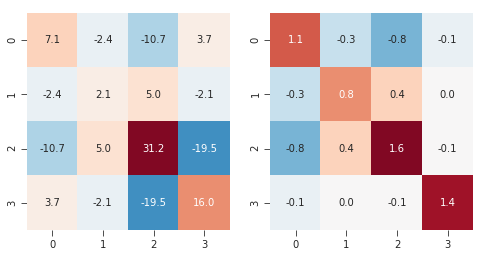

In [7]:
pre_sample = np.linalg.inv(np.cov(features, rowvar=0))
pre_estimate = mgm.beta
f, axes = plt.subplots(1, 2, figsize=[8, 4])
sns.heatmap(pre_sample, ax=axes[0], cmap=palette, cbar=False, annot=True, center=0, fmt='.1f')
sns.heatmap(pre_estimate, ax=axes[1], cmap=palette, cbar=False, annot=True, center=0, fmt='.1f')

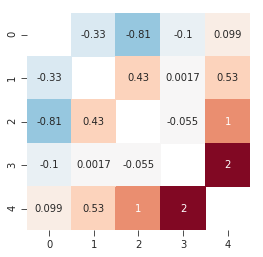

In [8]:
adj_cc = mgm.beta
adj_dc = np.linalg.norm(mgm.rho, axis=1)
adj_u = np.hstack((adj_cc, adj_dc.reshape(-1, 1)))
adj_l = np.append(adj_dc, 0)
adj = np.vstack((adj_u, adj_l))
adj[np.eye(5, dtype=bool)] = np.nan
plt.figure(figsize=[4, 4])
sns.heatmap(adj, cmap=palette, cbar=False, annot=True, center=0)

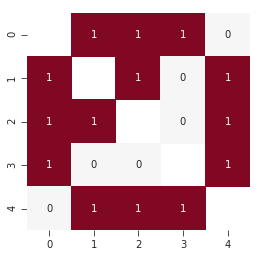

In [9]:
adj_cc = mgm.beta
adj_dc = np.linalg.norm(mgm.rho, axis=1)
adj_u = np.hstack((adj_cc, adj_dc.reshape(-1, 1)))
adj_l = np.append(adj_dc, 0)
adj = np.vstack((adj_u, adj_l))
adj = (np.abs(adj) > 0.1).astype(float)
adj[np.eye(5, dtype=bool)] = np.nan
plt.figure(figsize=[4, 4])
sns.heatmap(adj, cmap=palette, cbar=False, annot=True, center=0)

In [12]:
mgm2 = MixedGraphicalModel(lamb=0.5, eta=1e-6)
mgm2.fit(features, target)

Epoch: 10000 loss= 1121.604248047
Epoch: 20000 loss= 848.255432129


(842.11108, True)

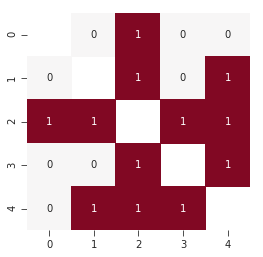

In [13]:
adj_cc = mgm2.beta
adj_dc = np.linalg.norm(mgm2.rho, axis=1)
adj_u = np.hstack((adj_cc, adj_dc.reshape(-1, 1)))
adj_l = np.append(adj_dc, 0)
adj2 = np.vstack((adj_u, adj_l))
adj2 = (np.abs(adj2) > 0.1).astype(float)
adj2[np.eye(5, dtype=bool)] = np.nan
plt.figure(figsize=[4, 4])
sns.heatmap(adj2, cmap=palette, cbar=False, annot=True, center=0)

In [14]:
df = pd.DataFrame(features)
df['class'] = target

In [15]:
n, d = df.values.shape
edges = knn.learn_mrf(df.values)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj3 = nx.adjacency_matrix(g).toarray().astype(float)
adj3[np.eye(d, dtype=bool)] = np.nan

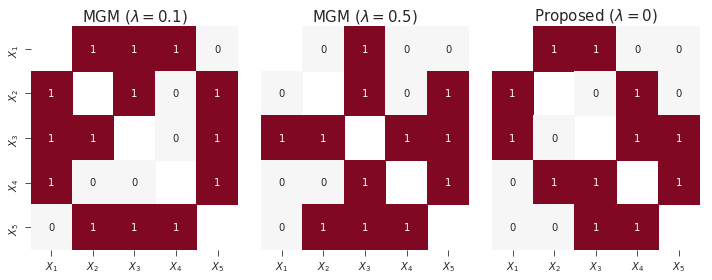

In [17]:
f, axes = plt.subplots(1, 3, figsize=[10, 4])
axes[0].set_title('MGM ($\lambda = 0.1$)', fontsize=15)
axes[1].set_title('MGM ($\lambda = 0.5$)', fontsize=15)
axes[2].set_title('Proposed ($\lambda = 0$)', fontsize=15)
labels = ['$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
sns.heatmap(adj, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False, xticklabels=labels, yticklabels=labels)
sns.heatmap(adj2, annot=True, center=0, ax=axes[1], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
sns.heatmap(adj3, annot=True, center=0, ax=axes[2], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
plt.tight_layout()
plt.savefig('output/heat-iris.pdf', format='pdf')

In [ ]:
sns.pairplot(df, hue='class')